Case 1 - when images are in folder according to class label code split into 80% and 20%

https://www.kaggle.com/datasets/erkamk/cat-and-dog-images-dataset


Case 2 images already in train set test set folder
- Keras expects case 2


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 5s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


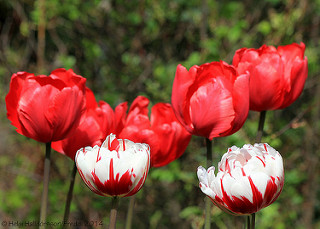

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

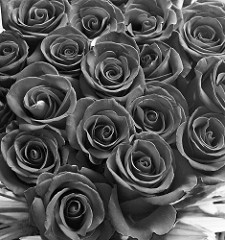

In [5]:
PIL.Image.open(str(roses[5]))

In [6]:
#rose dir
image_roses=data_dir/'roses'
img_files=list(image_roses.glob('*.jpg'))


rose_image=img_files[0]
image=PIL.Image.open(rose_image)
print(image.height,image.width)

229 320


In [7]:
sub_folders = [i for i in data_dir.iterdir() if i.is_dir()]

print("Label names:")
for label in sub_folders:
    print(label.name)

Label names:
roses
dandelion
sunflowers
daisy
tulips


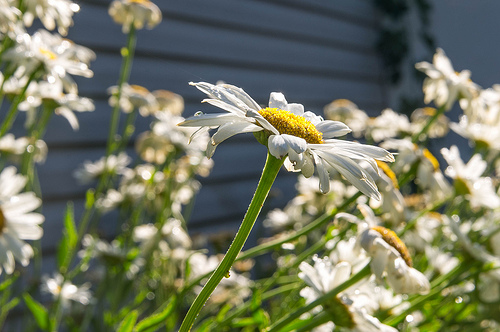

In [8]:
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[0]))

In [9]:
# Create a Training Dataset
train_ds=tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     validation_split=0.2,
                                                     subset='training',
                                                     seed=123,
                                                     image_size=(180,180),
                                                     batch_size=32
                                                     )


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
# Create a Validation Dataset
test_ds=tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     seed=123,
                                                     image_size=(180,180),
                                                     batch_size=32
                                                     )

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names=train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
# display images
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# display images
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(2): #can change take
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Steps:
Data Preprocessing
- normalization
- data augmentation
- CNN Arch

tune the numbers of parallel calls during data preprocessing, transformation operations

- shuffle see a diverse range
- prefetch: enhance memory performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# data normalisation

normalisation_layer = layers.Rescaling(1./255)

#map applies to whole data
normalized_ds = train_ds.map(lambda x, y: (normalisation_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [ ]:
model.summary()

Two procedures to create same architecture:

1. Normalization, Data Augmentation, hidden layer. part of model layers. executing when model is executing
2. should already be done. Use Image Data Generator. not need to add as a layer

Other way data data gen not part of model summary

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# run
epochs=3
history=model.fit(train_ds,
                  validation_data=test_ds,
                  epochs=epochs)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 12s 57ms/step - loss: 1.5407 - accuracy: 0.3290 - val_loss: 1.1527 - val_accuracy: 0.5218
Epoch 2/3
92/92 [==============================] - 3s 30ms/step - loss: 1.0854 - accuracy: 0.5668 - val_loss: 1.0431 - val_accuracy: 0.5790
Epoch 3/3
92/92 [==============================] - 3s 29ms/step - loss: 0.9788 - accuracy: 0.6185 - val_loss: 1.0489 - val_accuracy: 0.5708


In [ ]:
# test accuracy
print('Test Score',model.evaluate(test_ds))

23/23 [==============================] - 0s 9ms/step - loss: 1.0489 - accuracy: 0.5708
Test Score [1.048853874206543, 0.5708447098731995]


In [ ]:
# train accuracy
print('Train Score',model.evaluate(train_ds))

92/92 [==============================] - 1s 8ms/step - loss: 0.9646 - accuracy: 0.6189
Train Score [0.9646396040916443, 0.6188691854476929]


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

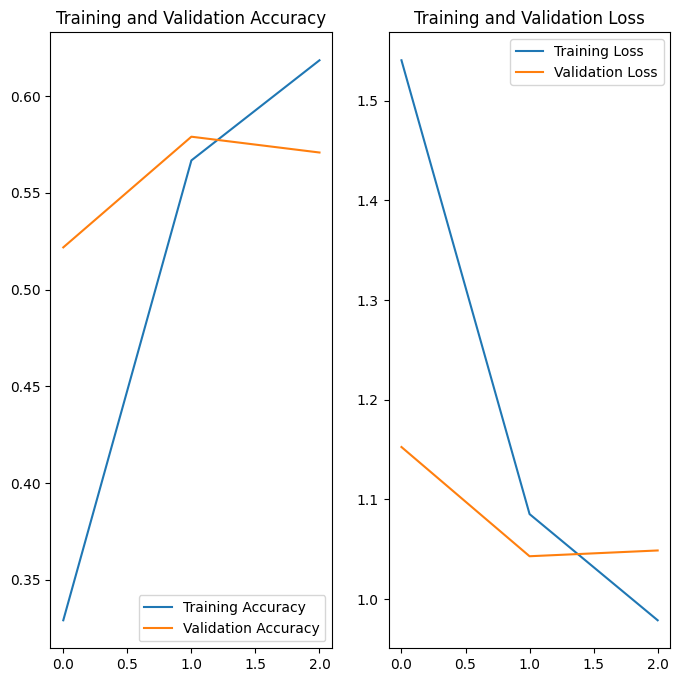

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#should process it in the same way
#hence height, width, change to array, expand dims
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)


img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 260ms/step
This image most likely belongs to roses with a 28.35 percent confidence.


In [ ]:
# run
epochs=50
history=model.fit(train_ds,
                  validation_data=test_ds,
                  epochs=epochs)

Epoch 1/50
92/92 [==============================] - 3s 31ms/step - loss: 0.9438 - accuracy: 0.6342 - val_loss: 0.9274 - val_accuracy: 0.6458
Epoch 2/50
92/92 [==============================] - 3s 28ms/step - loss: 0.8644 - accuracy: 0.6608 - val_loss: 0.8821 - val_accuracy: 0.6499
Epoch 3/50
92/92 [==============================] - 3s 29ms/step - loss: 0.8335 - accuracy: 0.6846 - val_loss: 0.8395 - val_accuracy: 0.6921
Epoch 4/50
92/92 [==============================] - 3s 31ms/step - loss: 0.7882 - accuracy: 0.6996 - val_loss: 0.8193 - val_accuracy: 0.6717
Epoch 5/50
92/92 [==============================] - 3s 28ms/step - loss: 0.7497 - accuracy: 0.7115 - val_loss: 0.7972 - val_accuracy: 0.6798
Epoch 6/50
92/92 [==============================] - 3s 29ms/step - loss: 0.7169 - accuracy: 0.7285 - val_loss: 0.7656 - val_accuracy: 0.6962
Epoch 7/50
92/92 [==============================] - 3s 34ms/step - loss: 0.6757 - accuracy: 0.7497 - val_loss: 0.7328 - val_accuracy: 0.6948
Epoch 8/50
92

In [ ]:
# test accuracy
print('Test Score',model.evaluate(test_ds))

23/23 [==============================] - 0s 7ms/step - loss: 0.9960 - accuracy: 0.7670
Test Score [0.9960439205169678, 0.7670300006866455]


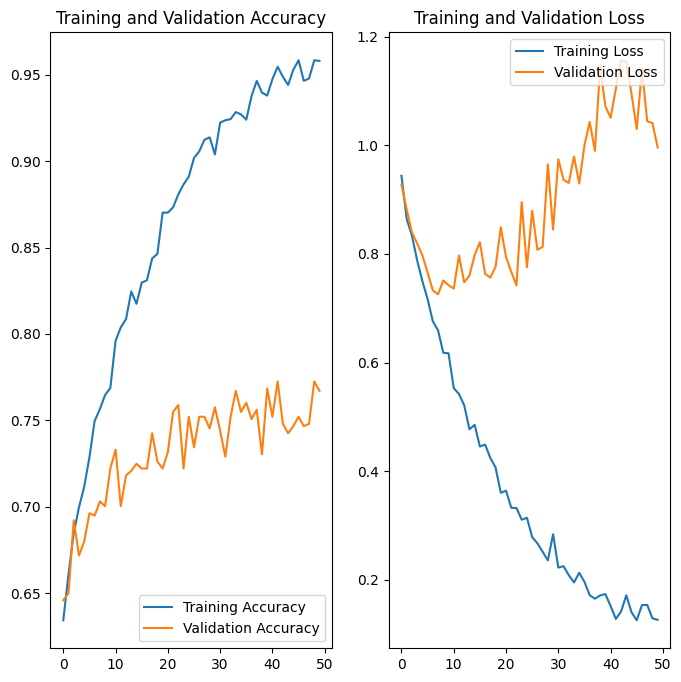

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()